Imports

In [1]:
%pip install tensorflow


import matplotlib.pyplot as plt
import numpy as np
import os
# import PIL
# from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds
import seaborn as sn; sn.set(font_scale=1.4)
# from sklearn.utils import shuffle           
from skimage.io import imread
from keras.layers import Input, Dense
from tensorflow import keras
from keras import layers
# from keras.datasets import mnist
from keras.models import Sequential
from skimage import transform
from skimage.color import rgb2gray
from keras.utils.vis_utils import plot_model
# from keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# from sklearn.preprocessing import LabelEncoder
import os.path
from os import path

from google.colab import drive 

# import cv2                                 
# from tqdm import tqdm
# from collections import Counter
# from keras.preprocessing.image import ImageDataGenerator
# import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
def clone_or_pull(repo_directory, repo_url):
  if path.exists(repo_directory):
      %cd $repo_directory
      !git reset --hard HEAD
      !git pull --force origin main
  else:
      !git clone $repo_url

drive.mount('/content/drive', force_remount=True)
%cd /content/drive/My Drive/

REPO_DIR='utn-ia-2023'
REPO_URL='https://github.com/RonanCamargo/utn-ia-2023'
clone_or_pull(REPO_DIR, REPO_URL)


Mounted at /content/drive
/content/drive/My Drive
/content/drive/My Drive/utn-ia-2023
Updating files: 100% (962/962), done.
HEAD is now at 8eae332 Add notebooks
From https://github.com/RonanCamargo/utn-ia-2023
 * branch            main       -> FETCH_HEAD
Already up to date.


Configuraciones

In [102]:
dataset_dir = "/content/drive/My Drive/utn-ia-2023/dataset"
training_images_folder="train"
test_images_folder="test"

training_dir = os.path.join(dataset_dir, training_images_folder)
testing_dir = os.path.join(dataset_dir, test_images_folder)

# felines = !ls training_dir
felines = ['Guepardo','Jaguar','Puma','Leopardo_de_nieve']
# image_size = (32, 32)
image_size = (200, 200)
# model_input_shape = image_size + (1,) #grayscale
model_input_shape = image_size + (3,) #color
output_layer_neurons = len(felines) # image type array length
hidden_layer_neurons = [512, 512, 512]
training_epochs = 600
learning_rate = 0.0001
training_batch_size = 64

#https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/
#https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/
hidden_layer_activation_function = 'relu'
output_layer_activation_function = 'softmax'

Funciones auxiliares

In [132]:

import os
import numpy as np
from skimage.io import imread

def load_images(directory):
    labels = []
    images = []
    label_index = 0

    subdirectories = sorted(os.listdir(directory))  # Sort subdirectories by name

    for subdirectory in subdirectories:
        if os.path.isdir(os.path.join(directory, subdirectory)):
            label_directory = os.path.join(directory, subdirectory)
            file_names = [os.path.join(label_directory, f) 
                          for f in os.listdir(label_directory) 
                          if f.lower().endswith((".jpg", ".jpeg"))]

            for file_name in file_names:
                image = imread(file_name)
                images.append(image)
                labels.append(label_index)
                print(file_name)
                print(label_index)

            label_index += 1

    return np.array(images), np.array(labels)

import numpy as np
from skimage.transform import resize

def resize_images(images, image_resize):
    processed_images = []

    for image in images:
        try:
            processed_image = resize(image, image_resize)
            processed_images.append(processed_image)
        except Exception as e:
            print(f"An error occurred while resizing an image: {str(e)}")

    return np.array(processed_images)

Cambiar tamaño y convertir a escala de grises

In [135]:
training_images_gray, training_labels = load_images(training_dir)
# training_images_gray = resize_images(training_images, image_size)

# training_images_resized = resize_images(training_images, image_size)
# training_images_gray = rgb2gray(training_images_resized)

test_images_gray, test_labels = load_images(testing_dir)
# test_images_gray = resize_images(test_images, image_size)

# test_images_resized = resize_images(test_images, image_size)
# test_images_gray = rgb2gray(test_images_resized)

/content/drive/My Drive/utn-ia-2023/dataset/train/Guepardo/051.jpg
0
/content/drive/My Drive/utn-ia-2023/dataset/train/Guepardo/052.jpg
0
/content/drive/My Drive/utn-ia-2023/dataset/train/Guepardo/053.jpg
0
/content/drive/My Drive/utn-ia-2023/dataset/train/Guepardo/054.jpg
0
/content/drive/My Drive/utn-ia-2023/dataset/train/Guepardo/055.jpg
0
/content/drive/My Drive/utn-ia-2023/dataset/train/Guepardo/056.jpg
0
/content/drive/My Drive/utn-ia-2023/dataset/train/Guepardo/057.jpg
0
/content/drive/My Drive/utn-ia-2023/dataset/train/Guepardo/058.jpg
0
/content/drive/My Drive/utn-ia-2023/dataset/train/Guepardo/060.jpg
0
/content/drive/My Drive/utn-ia-2023/dataset/train/Guepardo/059.jpg
0
/content/drive/My Drive/utn-ia-2023/dataset/train/Guepardo/061.jpg
0
/content/drive/My Drive/utn-ia-2023/dataset/train/Guepardo/062.jpg
0
/content/drive/My Drive/utn-ia-2023/dataset/train/Guepardo/063.jpg
0
/content/drive/My Drive/utn-ia-2023/dataset/train/Guepardo/065.jpg
0
/content/drive/My Drive/utn-ia-202

Modelo (RNA)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_55 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 52, 52, 256)       147712    
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 26, 26, 256)    

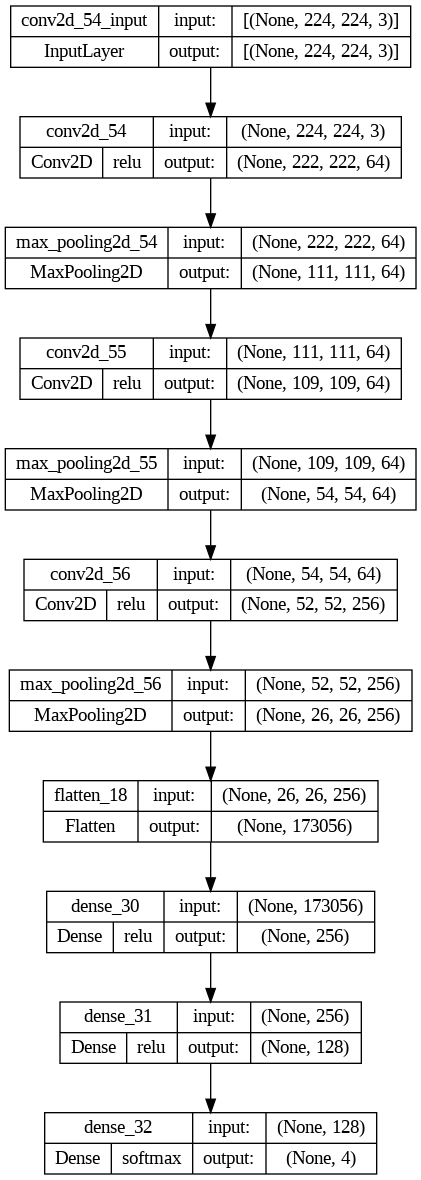

In [136]:
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Dropout


# model= Sequential([
#     Flatten(input_shape = (32,32,3), name = "entrada"),
#     Dense(hidden_layer_neurons[0], activation=hidden_layer_activation_function, name = "capa_oculta_1"),
#     # Dense(hidden_layer_neurons[1], activation=hidden_layer_activation_function, name = "capa_oculta_2"),
#     # Dropout(0.2),
#     # Dense(hidden_layer_neurons[2], activation=hidden_layer_activation_function, name = "capa_oculta_3"),
#     Dense(output_layer_neurons, activation=output_layer_activation_function, name="salida")
# ])

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=64, 
                         kernel_size=3, 
                         activation="relu", 
                         input_shape=(224,224,3)), 
  # tf.keras.layers.Conv2D(32, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
  # tf.keras.layers.Conv2D(32, 3, activation="relu"),
  tf.keras.layers.Conv2D(64, 3, activation="relu"), 
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Conv2D(256, 3, activation="relu"), 
  tf.keras.layers.MaxPool2D(2),
  # tf.keras.layers.Conv2D(512, 3, activation="relu"), 
  # tf.keras.layers.MaxPool2D(2),
  # tf.keras.layers.Conv2D(512, 3, activation="relu"), 
  # tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation="relu"), 
  tf.keras.layers.Dense(128, activation="relu"), 
  tf.keras.layers.Dense(output_layer_neurons, activation="softmax") 
])

model.compile(keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"])

model.summary()
plot_model(model, 
           show_layer_names = True, 
           show_shapes = True, 
           show_layer_activations = True,
          #  show_dtype = True
           )

Entrenar modelo

In [137]:
history = model.fit(np.array(training_images_gray), 
                    training_labels,
                    batch_size = 32,
                    epochs = 15,
                    workers = 1,
                    use_multiprocessing = False)

Epoch 1/15
24/24 [==============================] - 4s 76ms/step - loss: 53.9557 - accuracy: 0.3243
Epoch 2/15
24/24 [==============================] - 2s 74ms/step - loss: 2.2341 - accuracy: 0.5635
Epoch 3/15
24/24 [==============================] - 2s 75ms/step - loss: 0.7582 - accuracy: 0.7770
Epoch 4/15
24/24 [==============================] - 2s 77ms/step - loss: 0.1695 - accuracy: 0.9446
Epoch 5/15
24/24 [==============================] - 2s 75ms/step - loss: 0.0789 - accuracy: 0.9770
Epoch 6/15
24/24 [==============================] - 2s 75ms/step - loss: 0.0243 - accuracy: 0.9986
Epoch 7/15
24/24 [==============================] - 2s 75ms/step - loss: 0.0109 - accuracy: 1.0000
Epoch 8/15
24/24 [==============================] - 2s 75ms/step - loss: 0.0049 - accuracy: 1.0000
Epoch 9/15
24/24 [==============================] - 2s 75ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 10/15
24/24 [==============================] - 2s 75ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 11

Información sobre el entrenamiento

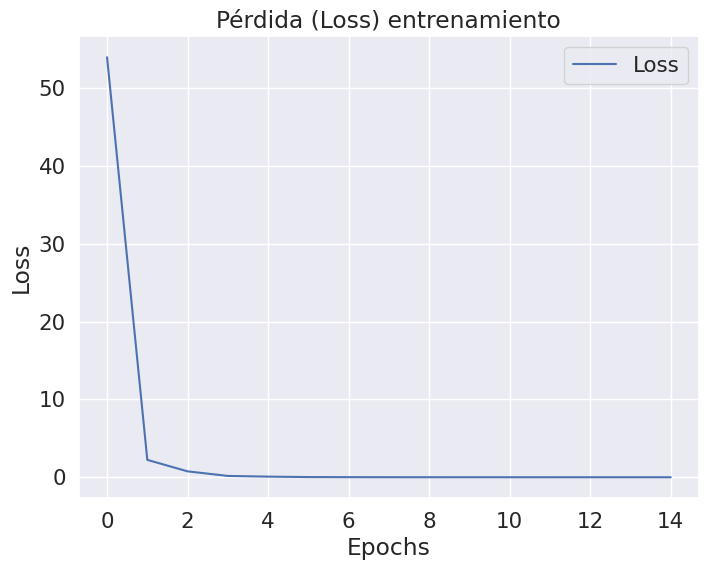

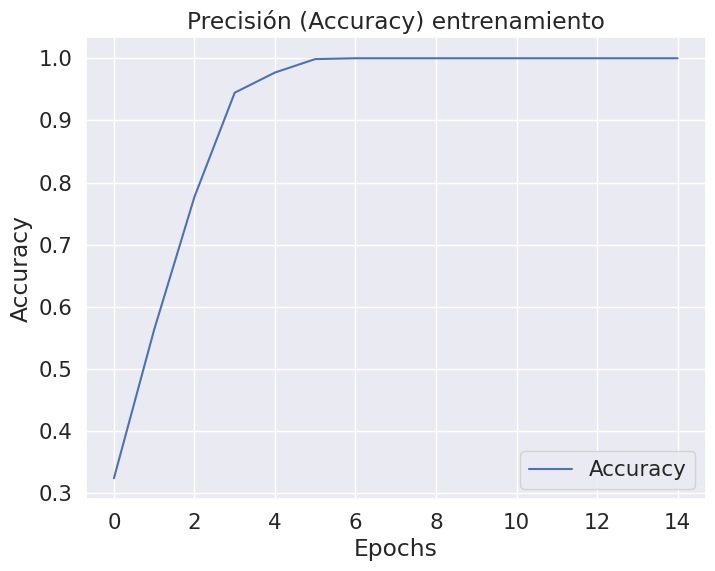

In [138]:
import matplotlib.pyplot as plt
import numpy as np

# Extract loss and accuracy values from the history object
loss = history.history['loss']
accuracy = history.history['accuracy']

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(loss, label='Loss')
plt.title('Pérdida (Loss) entrenamiento')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(accuracy, label='Accuracy')
plt.title('Precisión (Accuracy) entrenamiento')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Clasificar imágenes


In [139]:
print_summary = 2
test_loss, test_acc = model.evaluate(test_images_gray, test_labels, verbose=print_summary)
print(test_images_gray)
print(test_labels)

print("Resultado de clasificación: ")
print('\tExactitud de prueba:', test_acc)
print('\tPérdida:', test_loss)

predictions = model.predict(test_images_gray)

7/7 - 0s - loss: 1.1310 - accuracy: 0.7670 - 313ms/epoch - 45ms/step
[[[[223 204 187]
   [225 206 189]
   [225 206 189]
   ...
   [209 192 174]
   [211 194 176]
   [213 196 178]]

  [[222 203 186]
   [223 204 187]
   [223 204 187]
   ...
   [208 191 173]
   [210 193 175]
   [213 196 178]]

  [[220 201 184]
   [222 203 186]
   [221 202 185]
   ...
   [208 191 173]
   [210 193 175]
   [213 196 178]]

  ...

  [[223 202 171]
   [224 201 170]
   [226 202 174]
   ...
   [229 213 180]
   [228 214 177]
   [232 218 179]]

  [[225 202 171]
   [226 203 172]
   [226 202 174]
   ...
   [227 211 178]
   [229 215 178]
   [230 218 178]]

  [[228 205 174]
   [223 200 169]
   [227 203 175]
   ...
   [223 207 174]
   [229 215 178]
   [225 213 175]]]


 [[[ 63  68  45]
   [ 65  71  45]
   [ 69  75  47]
   ...
   [112 120  97]
   [115 122 104]
   [121 128 112]]

  [[ 64  70  44]
   [ 67  73  47]
   [ 70  76  48]
   ...
   [121 129 108]
   [122 129 111]
   [126 133 117]]

  [[ 64  70  44]
   [ 67  73  47]


Matriz de confusión

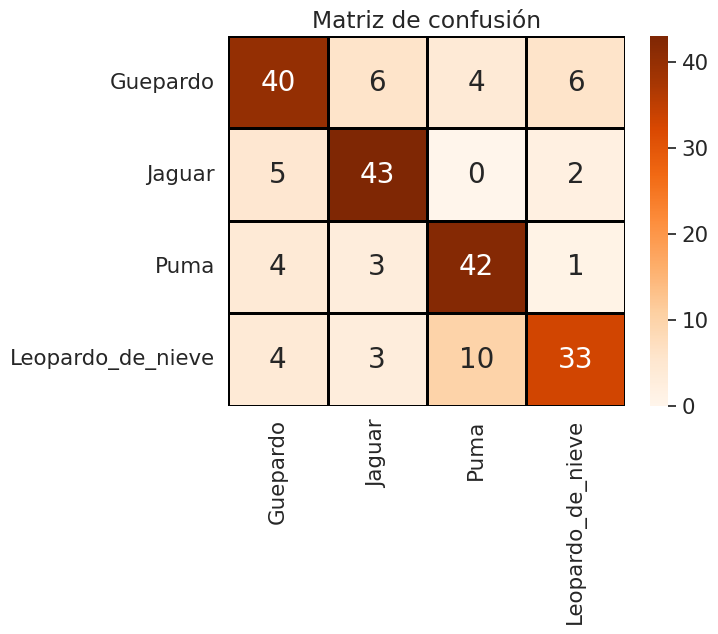

In [140]:
#https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/#:~:text=Plot%20Confusion%20Matrix%20for%20Binary%20Classes%20With%20Labels&text=You%20need%20to%20create%20a,matrix%20with%20the%20labels%20annotation.
axes = plt.axes()
axes.set_title('Matriz de confusión')
axes.set_ylabel('Original')
axes.set_xlabel('Clasificación')

#https://matplotlib.org/stable/tutorials/colors/colormaps.html
colormap='Oranges'

pred_labels = np.argmax(predictions, axis = 1)
matrix = confusion_matrix(test_labels, pred_labels)

sn.heatmap(matrix, annot=True, annot_kws={"size": 20}, xticklabels=felines, yticklabels=felines, ax=axes, cmap=colormap,cbar=True,linecolor='black',linewidths=2)
plt.show()

In [141]:
predictions = model.predict(test_images_gray)
y_pred = np.argmax(predictions, axis=1)

print('Reporte de clasificación')
print(classification_report(test_labels, y_pred, target_names=felines, zero_division=0))

7/7 [==============================] - 0s 24ms/step
Reporte de clasificación
                   precision    recall  f1-score   support

         Guepardo       0.75      0.71      0.73        56
           Jaguar       0.78      0.86      0.82        50
             Puma       0.75      0.84      0.79        50
Leopardo_de_nieve       0.79      0.66      0.72        50

         accuracy                           0.77       206
        macro avg       0.77      0.77      0.77       206
     weighted avg       0.77      0.77      0.76       206



Funciones clasificación

In [99]:
def label_color(predicted, original):
  if predicted == original:
    return 'green'
  else:
    return 'red'

def plot_image(i, predictions_array, right_label, img):
  predictions_array, right_label, img = predictions_array, right_label[i], img[i]
  predicted_label = np.argmax(predictions_array)
  color = label_color(predicted_label, right_label)

  plt.xticks([])
  plt.yticks([])
  plt.imshow(img, cmap=plt.cm.binary)
  plt.title("{}".format(felines[right_label]))
  plt.xlabel("Clasificación: {}".format(felines[predicted_label]), color=color)
    
def plot(predictions, test_labels, test_images):
  for i in range(len(predictions)):
    plt.figure(figsize=(12,30))
    plt.subplot(1,2,1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.show()


Mostrar clasificación

In [142]:
# plot(predictions, test_labels, test_images)